In [1]:
spark

In [2]:
dir0 = '/home/cloudera/2.kkbox_churn/data01/big_table_01/has-expired_auto-renew-0/last-1-week_has-record/'
infile = dir0 + '01.added_features'

df0 = spark.read.format('parquet').load(infile)

In [3]:
df0.columns

['msno',
 'city',
 'age',
 'gender',
 'registered_via',
 'days_since_init_regist',
 'init_date',
 'final_date',
 'gaps_count',
 'total_gap_len',
 'has_long_gap',
 'has_expired',
 'last_pay_method',
 'last_plan_days',
 'last_list_price',
 'last_actual_paid',
 'last_discount',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'actual_paid_mode',
 'auto_renew_cnt_uniq',
 'auto_renew_mode',
 'discount_cnt_uniq',
 'discount_mode',
 'list_price_cnt_uniq',
 'list_price_mode',
 'pay_method_cnt_uniq',
 'pay_method_mode',
 'plan_days_cnt_uniq',
 'plan_days_mode',
 'actual_paid_sum',
 'actual_paid_per_sub_day',
 'discount_sum',
 'discount_per_sub_day',
 'list_price_sum',
 'list_price_per_sub_day',
 'last12WeekOnLine',
 'w12_M25',
 'w12_M50',
 'w12_M75',
 'w12_M985',
 'w12_M100',
 'w12_Munq',
 'w12_Msecs',
 'w12_Mtotal',
 'w12_M25_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal',
 'w12_M25M50M75_D_Mtotal',
 'w12_M985M100_D_Mtotal',

In [17]:
cols_categorical = [
    'msno',
    'city',
    #'gender',       # too many null's
    'registered_via',
    'has_long_gap',
    'last_pay_method',
    'pay_method_mode',
]

df0_categ = df0.select(cols_categorical)

In [18]:
cols_continuous = [
    # (selected after inspecting the correlation matrix)
    'msno',
    # --
    #'age'       # too many null's
    'days_since_init_regist',
    # --
    'total_gap_len',
    'last_list_price',
    'last_paid_per_day',
    'actual_paid_cnt_uniq',
    'auto_renew_cnt_uniq',
    'discount_sum',
    # --
    'last1WeekOnLine',
    'last1WeekOnLine_D_last12WeekOnLine', 
    'w1_M75',
    'w12_M75',
    'w1_M985',
    #'w1_M985_D_w12_M985',  # difficulty due to 0/0
    'w1_Mtotal',
    'w1_Mtotal_D_w12_Mtotal',  
    'w1_M25_D_Mtotal',
    'w1_M50_D_Mtotal',
    'w12_M50_D_Mtotal',
    'w1_Munq_D_Mtotal',
]

print(len(cols_continuous))
df1 = df0.select(cols_continuous)

19


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_histograms(df, cols, nFigCols, cols_ylog=[]):
    ''' Returns (fig, axes) '''
    nFigRows = int(math.ceil(len(cols)/nFigCols))
    fig, axes = plt.subplots(nFigRows, nFigCols)
    
    for r in range(nFigRows):
        for c in range(nFigCols):
            i = r*nFigCols + c
            if i >= len(cols):
                break
            arr = np.array(df.select(cols[i]).collect())
            axes[r, c].hist(arr, 40, log=(cols[i] in cols_ylog))
            axes[r, c].set(xlabel=cols[i], ylabel='count')
        
    fig.set_size_inches(15, 15)
    fig.subplots_adjust(hspace=0.45, wspace=0.3)
    
    return (fig, axes)

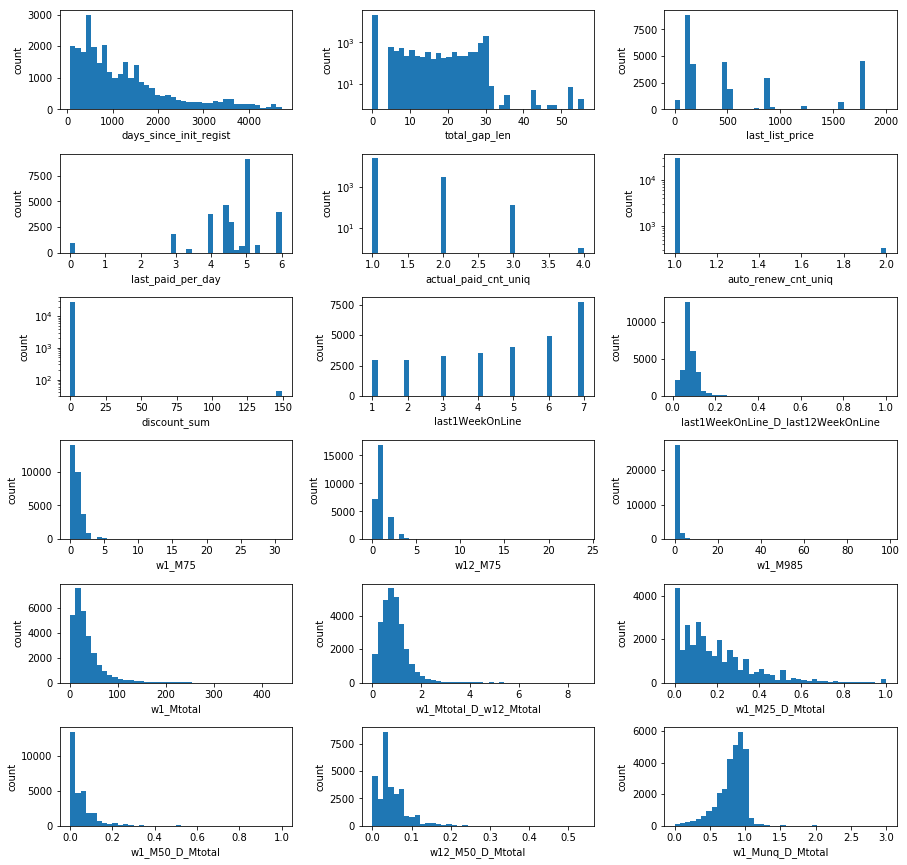

In [20]:
cols_ylog = ['total_gap_len', 'actual_paid_cnt_uniq', 'auto_renew_cnt_uniq', 'discount_sum']
fig, axes = plot_histograms(df1, [c for c in df1.columns if c!='msno'], 3, cols_ylog)
plt.show()

# feature selection 1

In [21]:
cols_cont_select = [
    'msno',
    ##
    'days_since_init_regist',
    ##
    'total_gap_len',
    'last_list_price',
    'last_paid_per_day',
    'actual_paid_cnt_uniq',
    #'auto_renew_cnt_uniq',  # almost all = 1
    #'discount_sum',         # almost all = 0
    ##
    'last1WeekOnLine',
    'last1WeekOnLine_D_last12WeekOnLine', 
    'w1_M75',
    'w12_M75',
    'w1_M985',
    #'w1_M985_D_w12_M985',   # difficulty due to 0/0
    'w1_Mtotal',
    'w1_Mtotal_D_w12_Mtotal',  
    'w1_M25_D_Mtotal',
    'w1_M50_D_Mtotal',
    'w12_M50_D_Mtotal',
    'w1_Munq_D_Mtotal',
]

print(len(cols_cont_select))
df1 = df0.select(cols_cont_select)

17


# transform & normalize 

## log or sqrt transform

In [22]:
df1.columns

['msno',
 'days_since_init_regist',
 'total_gap_len',
 'last_list_price',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'last1WeekOnLine',
 'last1WeekOnLine_D_last12WeekOnLine',
 'w1_M75',
 'w12_M75',
 'w1_M985',
 'w1_Mtotal',
 'w1_Mtotal_D_w12_Mtotal',
 'w1_M25_D_Mtotal',
 'w1_M50_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w1_Munq_D_Mtotal']

In [25]:
from pyspark.sql.functions import min

cols = [c  for c in df1.columns if c!='msno']
minCols = [min(c)  for c in cols]
dict(zip(cols, list(df1.select(*minCols).rdd.collect()[0])))

# minimums:

{'days_since_init_regist': 62,
 'total_gap_len': 0,
 'last_list_price': 0,
 'last_paid_per_day': 0.0,
 'actual_paid_cnt_uniq': 1,
 'last1WeekOnLine': 1,
 'last1WeekOnLine_D_last12WeekOnLine': 0.01,
 'w1_M75': 0,
 'w12_M75': 0,
 'w1_M985': 0,
 'w1_Mtotal': 1,
 'w1_Mtotal_D_w12_Mtotal': 0.01,
 'w1_M25_D_Mtotal': 0.0,
 'w1_M50_D_Mtotal': 0.0,
 'w12_M50_D_Mtotal': 0.0,
 'w1_Munq_D_Mtotal': 0.0}

In [26]:
"""
    'total_gap_len',
    'last_list_price',
    'last_paid_per_day',
    'actual_paid_cnt_uniq',
    'last1WeekOnLine',
"""              

cols_sqrt = [
    'w1_M75',
    'w12_M75',
    'w1_M985',
    'w1_M25_D_Mtotal',
    'w1_M50_D_Mtotal',
    'w12_M50_D_Mtotal',
    'w1_Munq_D_Mtotal',
]

cols_log = [
    'days_since_init_regist',
    'last1WeekOnLine_D_last12WeekOnLine',
    'w1_Mtotal',
    'w1_Mtotal_D_w12_Mtotal',
]


In [27]:
# transform
from pyspark.sql.functions import col, log10, sqrt

cols = []
for c in df1.columns:
    if c in cols_sqrt:
        cols.append(sqrt(c).alias(c+'_sqrt'))
    elif c in cols_log:
        cols.append(log10(c).alias(c+'_log'))
    else:
        cols.append(col(c))

df2 = df1.select(*cols)        

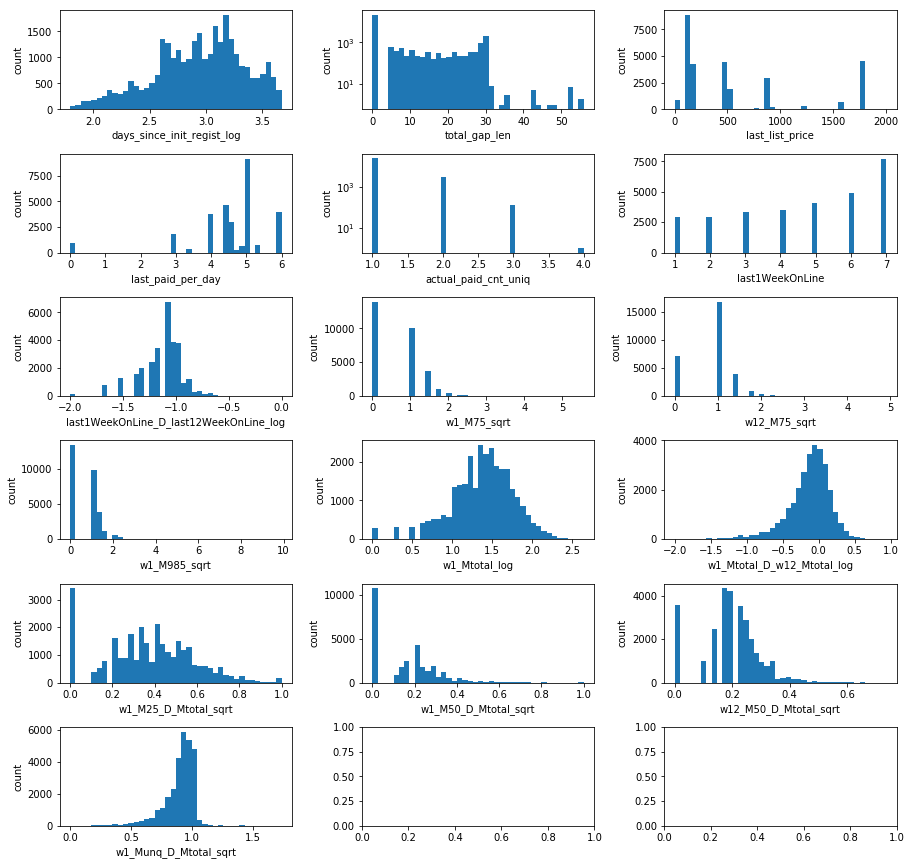

In [28]:
cols_ylog = ['total_gap_len', 'actual_paid_cnt_uniq']
fig, axes = plot_histograms(df2, [c for c in df2.columns if c!='msno'], 3, cols_ylog)
plt.show()

In [30]:
# output
df2 = df2.withColumnRenamed('msno', 'msno_')
df = df0_categ.join(df2, df0_categ['msno']==df2['msno_'], 'inner').drop('msno_')

outfile = dir0 + '02a.numeric_transformed'
df.write.format('parquet').save(outfile)

## normalize

In [55]:
# normalize
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler

va = VectorAssembler(inputCols=[c for c in df2.columns if not c.startswith('msno')], outputCol='features')
df = va.transform(df2)

#scaler = MinMaxScaler(inputCol='features', outputCol='features_normalized', min=0, max=1)
scaler = StandardScaler(inputCol='features', outputCol='features_normalized', 
                        withStd=True, withMean=True)
df3 = scaler.fit(df).transform(df) \
      .select('msno_', 'features_normalized')

df3.printSchema()

root
 |-- msno_: string (nullable = true)
 |-- features_normalized: vector (nullable = true)



In [56]:
df3.rdd.first()['features_normalized']

DenseVector([1.5881, -0.5531, 1.9732, -0.173, -0.3411, 0.1721, -0.1143, 0.5592, 0.2728, -0.9734, 0.1823, 0.442, 0.7547, 0.252, 0.0118, 0.4053])

In [57]:
from pyspark.sql.functions import col, round

def convert_vector_column_to_columns(df, pk_column, vector_column, expanded_columns):
    '''
    `pk_column` must be a primary key of `df`.
    Column `vector_column` of `df` must be of type DenseVector or SparseVector.
        
    Create new columns (with the names in expanded_columns[]) from `vector_column`.
    '''
    
    df_ = df.rdd.map(lambda row: [row[pk_column]] + row[vector_column].toArray().tolist()) \
          .toDF()
    assert len(df_.columns) == len(expanded_columns) + 1
    
    cols = [col('_1').alias(pk_column)]
    for i, c in enumerate(expanded_columns):
        cols.append(round('_{}'.format(i + 2), 6).alias(c))
    return df_.select(*cols)

In [58]:
df4 = convert_vector_column_to_columns(df3, 'msno_', 'features_normalized', 
                                       [c for c in df2.columns if not c.startswith('msno')])
df4.printSchema()

root
 |-- msno_: string (nullable = true)
 |-- days_since_init_regist_log: double (nullable = true)
 |-- total_gap_len: double (nullable = true)
 |-- last_list_price: double (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- actual_paid_cnt_uniq: double (nullable = true)
 |-- last1WeekOnLine: double (nullable = true)
 |-- last1WeekOnLine_D_last12WeekOnLine_log: double (nullable = true)
 |-- w1_M75_sqrt: double (nullable = true)
 |-- w12_M75_sqrt: double (nullable = true)
 |-- w1_M985_sqrt: double (nullable = true)
 |-- w1_Mtotal_log: double (nullable = true)
 |-- w1_Mtotal_D_w12_Mtotal_log: double (nullable = true)
 |-- w1_M25_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_M50_D_Mtotal_sqrt: double (nullable = true)
 |-- w12_M50_D_Mtotal_sqrt: double (nullable = true)
 |-- w1_Munq_D_Mtotal_sqrt: double (nullable = true)



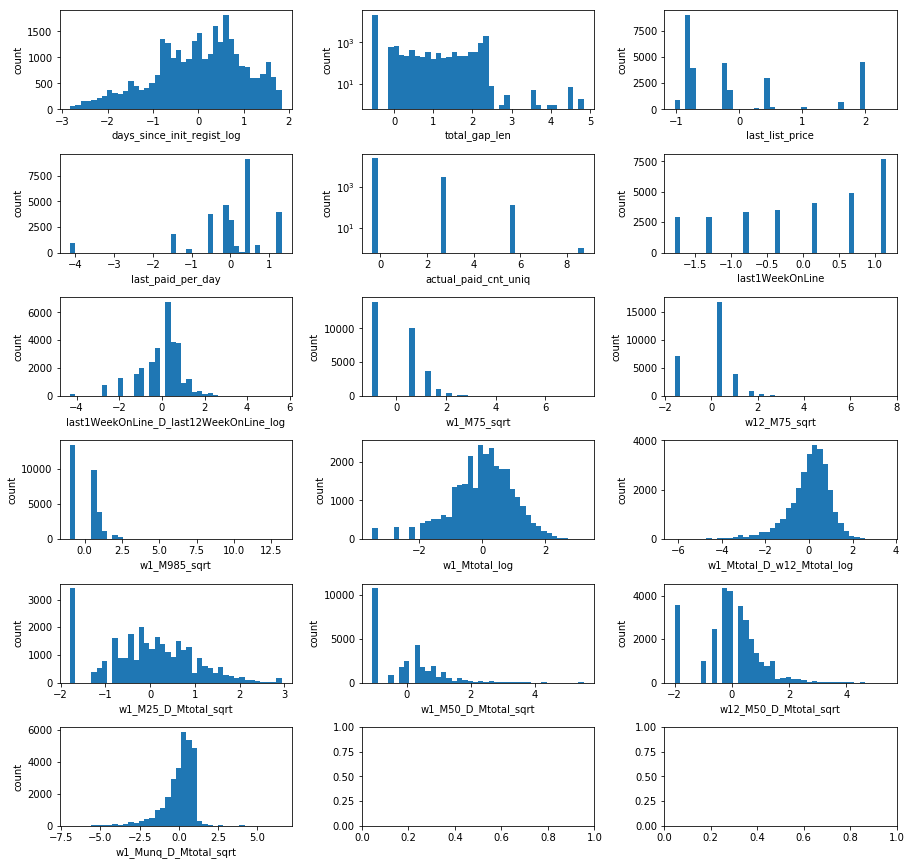

In [59]:
cols_ylog = ['total_gap_len', 'actual_paid_cnt_uniq']
fig, axes = plot_histograms(df4, [c for c in df4.columns if not c.startswith('msno')], 3, cols_ylog)
plt.show()

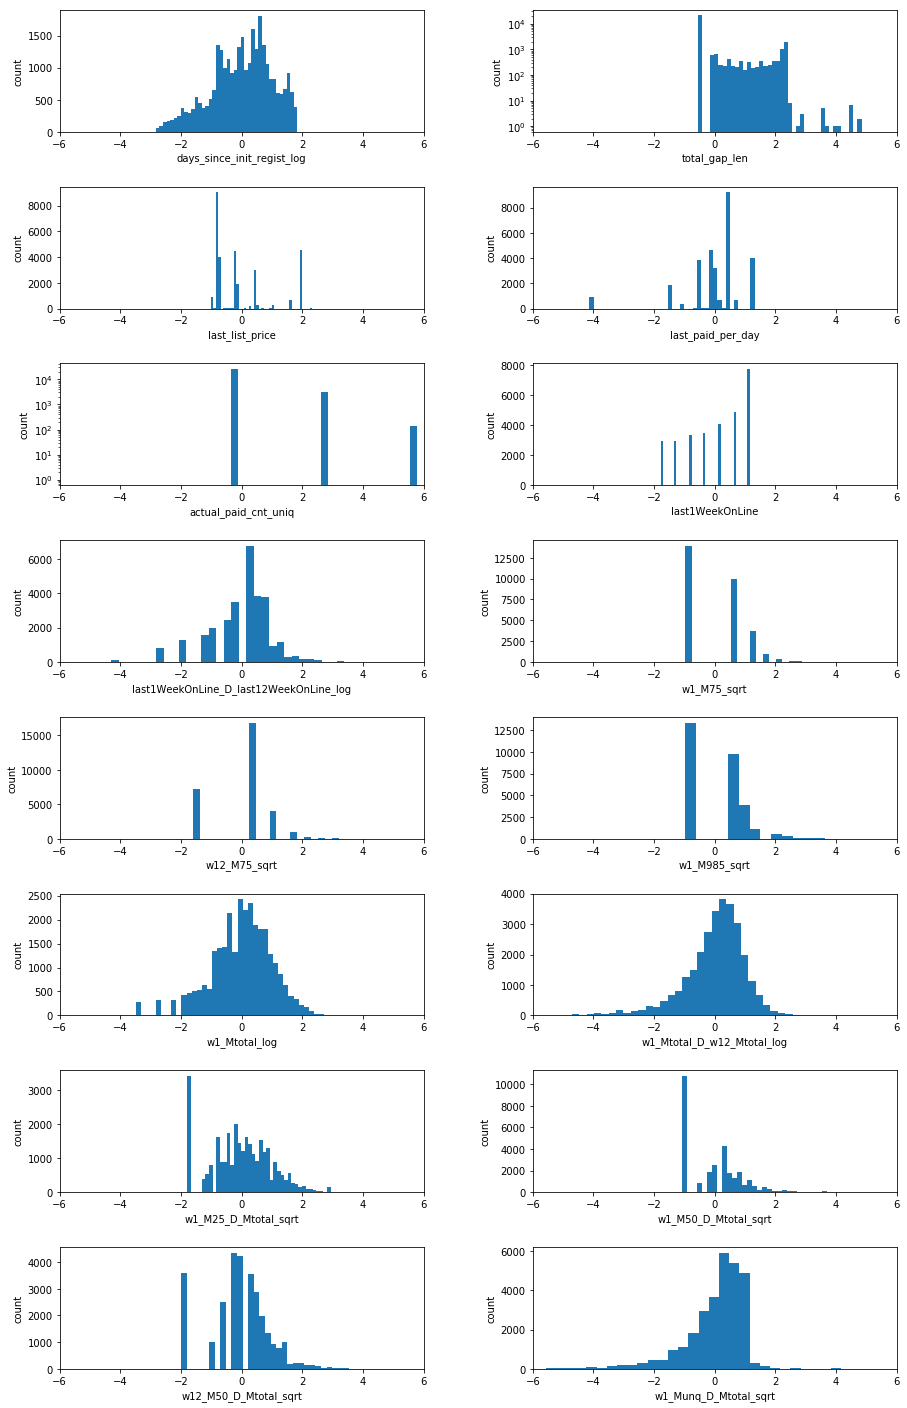

In [60]:
cols_ylog = ['total_gap_len', 'actual_paid_cnt_uniq']
fig, axes = plot_histograms(df4, [c for c in df4.columns if not c.startswith('msno')], 2, cols_ylog)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set(xlim=(-6,6))
fig.set_size_inches(15,25)    
fig.subplots_adjust(hspace=0.45)
plt.show()

In [61]:
# output
df = df0_categ.join(df4, df0_categ['msno']==df4['msno_'], 'inner')

outfile = dir0 + '02b.numeric_transformed_et_normalized'
df.coalesce(1).write.format('csv').option('header', 'true').save(outfile)